In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image 
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split #para separação de dados de treinamento e teste 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

        
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
discos=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 'disco' in dirname and 'wav' in os.path.join(dirname, filename):
            discos.append(os.path.join(dirname, filename))
elektronomia='/kaggle/input/vision-elektronomia/Elektronomia - vision (Free Download) - from YouTube (2) (online-audio-converter.com).wav'

# **NOTAS MIDI**

primeiro uma curiosidade. Notas musicais podem ser representadas como números segundo a escala MIDI

> 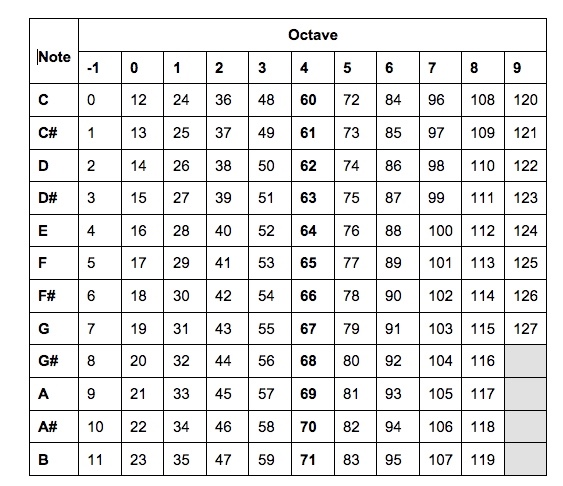

vamos ver o que o chromagrama pega numa música

In [ ]:
#lendo a música
#discos[9]: analisar essa musica depois
sound, sr = librosa.load(elektronomia)
plt.plot(sound)
plt.show()
ipd.Audio(sound,rate=sr)

**O ESTUDO DO CHROMA VAI SER FEITO NOS PRIMEIROS 10 SEGUNDOS DE MUSICA**

In [ ]:
x=sound[0:10*sr]
ipd.Audio(x, rate=sr)

agora algumas informações de chroma e cqt que retirei de um site:
 https://musicinformationretrieval.com/chroma.html

# CONSTANT-Q TRANSFORM

A tranformada de constante Q (não sei se é essa a tradução) utiliza eixos de frequência em escala logarítmica.

Judith C. Brown, "Calculation of a constant Q spectral transform," J. Acoust. Soc. Am., 89(1):425–434, 1991.

http://academics.wellesley.edu/Physics/brown/pubs/cq1stPaper.pdf

In [ ]:
#essa parte eu copiei de um site: https://musicinformationretrieval.com/chroma.html

fmin = librosa.midi_to_hz(36)#pega a frequencia em hz de notas MIDI
hop_length = 512
C = librosa.cqt(x, sr=sr, fmin=fmin, n_bins=72, hop_length=hop_length)

logC = librosa.amplitude_to_db(np.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

In [ ]:
print('tamanho da matriz =',C.shape)

# CHROMA

é um matriz de 12 linhas (em que cada linha é um vetor) que indica a quantidade energia de cada nota musical (C, C#, D, D#, E, ..., B)  presente no sinal. A função chroma_stft pega o chromagrama propriamente dito 

In [ ]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
print('tamanho da matriz =',chromagram.shape)

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

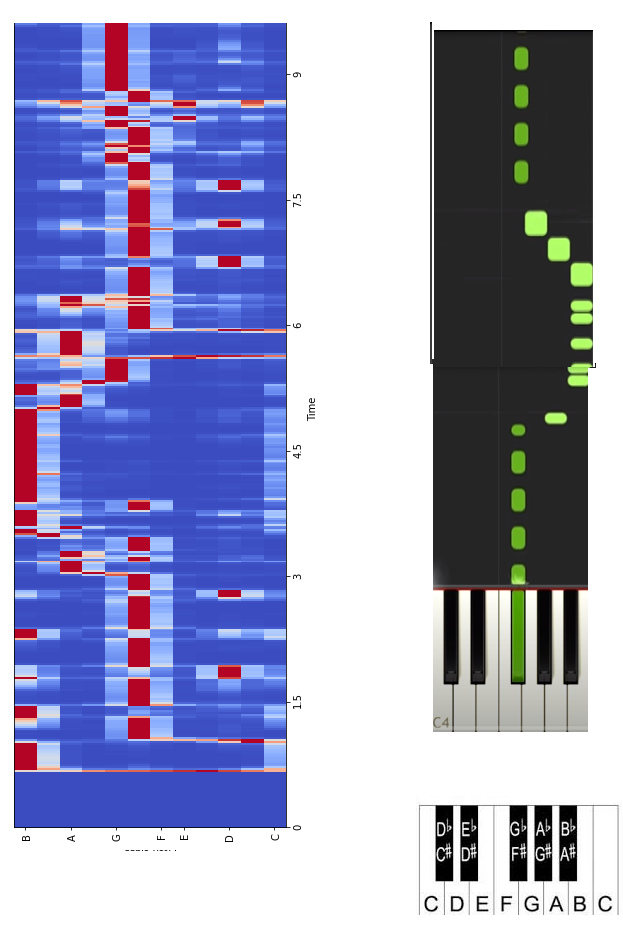

# Chroma_cqt

Constant-Q chromagram

é tipo um chromagrama só que aplicando escala log

In [ ]:
chromagram = librosa.feature.chroma_cqt(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# Chroma_cens

Computes the chroma variant “Chroma Energy Normalized” (CENS)

ele usa estatística para suavizar desvios locais no audio em acordes arpejados por exemplo. (não entendi nada, pq sei 0 coisas de musica). Como ele suaviza a música, ele é utilizado para determinar correspondências e similaridades de audios. Veja ele aplicado na música que estamos analisando

In [ ]:
chromagram = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# **VAMOS IDENTIFICAR O DROP EM UMA MÚSICA ELETRONICA**

A ideia é usar o rms para verificar a parte alta da musica. Para isso vamos dividir a musica em segundos e salvar o rms de cada segundo em uma lista e depois printar.

In [ ]:
#vou tentar só com rms

#vamo dividir a musica em segundos e salvar numa lista cada segundo

segundos_musica=[]

for segundo in range(0,int(len(sound)/sr)): #o tamanho de sound dividido pelo samplerate da a quantidade de segundos da musica
    segundo_musica=sound[(segundo-1)*sr:segundo*sr]
    segundos_musica.append(segundo_musica)
segundos_musica.pop(0)#tirar o segundo 0 que é vazio

#ouvir o segundo 0
ipd.Audio(segundos_musica[0], rate=sr)



In [ ]:
#agora vamos calcular o rms medio de cada segundo e salvar numa lista e depois plotar esses rms's

rms_de_cada_segundo=[]
for segundo_musica in segundos_musica:
    rms_medio_do_segundo=librosa.feature.rms(segundo_musica).mean()
    rms_de_cada_segundo.append(rms_medio_do_segundo)
plt.plot(rms_de_cada_segundo)
plt.xlabel('segundo')
plt.ylabel('RMS')
plt.show()


da pra ver claramente que tem dois drops na musica ou 3, talvez.

printando o rms médio total a gente ve q os drops estão bem acima do rms. Então a ideia é concatenar os segundos que tem rms maior que media em um numpy array chamado drop. Vamos ver o que acontece.

In [ ]:
rms_medio=np.array(rms_de_cada_segundo).mean()
print(rms_medio)

In [ ]:
#aqui faremos o drop e p
drop=np.zeros(0)
for posicao in range(len(rms_de_cada_segundo)):
    if rms_de_cada_segundo[posicao]>=rms_medio:
        drop=np.hstack([drop,segundos_musica[posicao]])  
plt.plot(drop)
plt.show()

vamos ouvir ele pra ver oq conseguimos pegar

In [ ]:
ipd.Audio(drop,rate=sr)